In [7]:
import torch
import datasets, networks, sampling, completion, evaluation
import matplotlib.pyplot as plt
from torch import nn

In [8]:
#HYPERPARAMETERS
num_epochs = 60

# TODO Select a optimizer. [ 'adam', 'adamw', 'rmsprop' ]
optimizer_option = 'adamw'


# TODO Select a batch size.
batch_size = 64

# TODO Select a learning rate.
lr = 0.0001


num_residual = 11
num_kernels = 64

Files already downloaded and verified


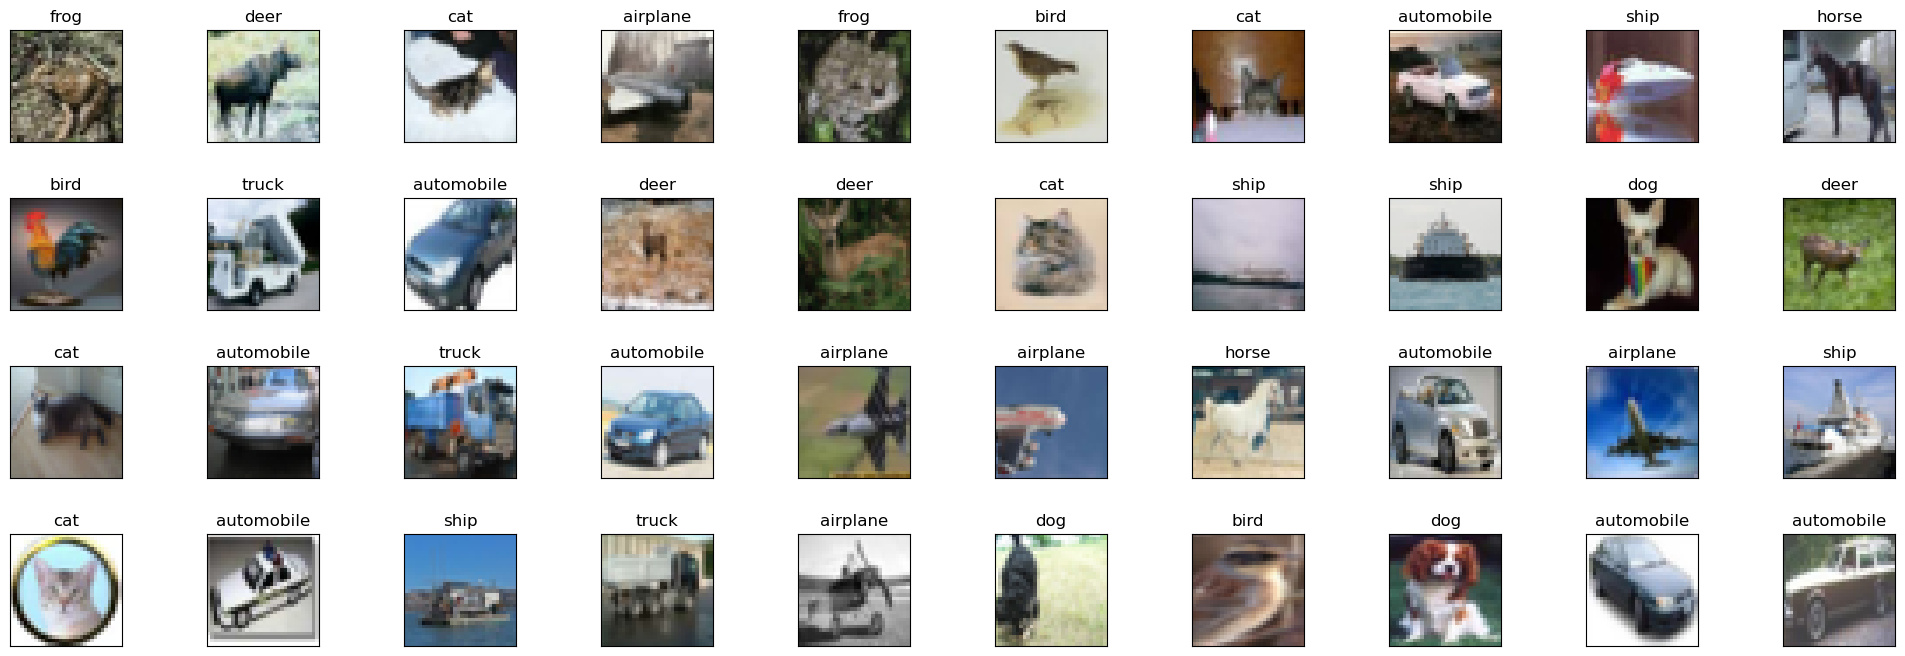

In [9]:
ds = datasets.Dataset('cifar10', batch_size=batch_size)
training_data = ds.get_train_data_loader()
test_data = ds.get_test_data_loader()

ds.visualize_dataset(training_data)

In [10]:
# Training
import time
from torch.optim import Adam, AdamW, RMSprop, SGD 

PixelCNN = networks.PixelCNN(num_kernels=num_kernels, num_residual=num_residual)

device = torch.device('cuda:0')
print(f'Using device: {device}')
print('=========================================')

PixelCNN.to(device)

learning_rates = []
train_loss_curve = []
test_loss_curve = []
train_loss_epochs = []
test_loss_epochs = []
optimizer = None

# Select optimizer
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(PixelCNN.parameters(), lr)
  
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(PixelCNN.parameters(), lr)
  
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(PixelCNN.parameters(), lr)
  
else:
  optimizer = torch.optim.SGD(PixelCNN.parameters(), lr, momentum=0.9)  


overall_start_time = time.time()

# training loop
for epoch in range(num_epochs):

  epoch_start_time = time.time()
  # Switch to training mode.
  PixelCNN.train()

  losses = []
  batch_idx = 0

  for images, labels in training_data:

    images = images.to(device)
    output = PixelCNN(images)

    images = images.view(-1)
    images = images*255
  
    output = torch.reshape(output, (batch_size, 256, 3, 32, 32))
    output = output.permute(0,2,3,4,1).contiguous().view(-1, 256)

    loss = nn.functional.cross_entropy(output, images.long())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(PixelCNN.parameters(), 1)
  
    optimizer.step()
    for param_group in optimizer.param_groups:
      learning_rates.append(param_group['lr'])
    optimizer.zero_grad()


    losses.append(loss.detach().clone())

    if batch_idx % 100 == 0:
      average_loss = torch.stack(losses).mean().item()
      train_loss_curve.append(average_loss)
      train_loss_epochs.append(epoch + 1)
      losses = []
      print(f'Epoch: {epoch + 1:3d}/{num_epochs:3d}, Batch {batch_idx + 1:5d}, Loss: {average_loss:.4f}')
    batch_idx += 1

  # scheduler.step()
  epoch_end_time = time.time()
  print('-----------------------------------------')
  print(f'Epoch: {epoch + 1:3d} took {epoch_end_time - epoch_start_time:.2f}s')
  test_loss = evaluation.evaluate(model=PixelCNN, test_data_loader=test_data, device=device, batch_size=batch_size)
  test_loss_curve.append(test_loss)
  test_loss_epochs.append(epoch + 1)
  print(f'Epoch: {epoch + 1:3d}, Test Loss: {test_loss:.4f}')
  print('-----------------------------------------')
  

  samples = sampling.sample(PixelCNN, num_samples=5)
  sampling.save_samples(samples)
  

overall_end_time = time.time()
print('=========================================')
print(f'Training took {overall_end_time - overall_start_time:.2f}s')

# Loss Curve Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, train_loss_curve, label='Train Loss')
plt.scatter(test_loss_epochs, test_loss_curve, color='red', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Learning Rate Plot
num_batches = len(training_data)
learning_rates_res = [sum(learning_rates[i * num_batches:(i + 1) * num_batches]) / num_batches for i in range(num_epochs)]
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), learning_rates_res)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Time')
plt.show()

Using device: cuda:0
Epoch:   1/ 60, Batch     1, Loss: 5.6302
Epoch:   1/ 60, Batch   101, Loss: 5.4617
Epoch:   1/ 60, Batch   201, Loss: 5.0598
Epoch:   1/ 60, Batch   301, Loss: 4.7904
Epoch:   1/ 60, Batch   401, Loss: 4.6367


KeyboardInterrupt: 

In [ ]:
torch.save(PixelCNN.state_dict(), 'PixelCNN_cifar10.pth')

In [ ]:
PixelCNN = networks.PixelCNN(num_kernels=128, num_residual=num_residual)
PixelCNN.to(torch.device("cuda"))
PixelCNN.load_state_dict(torch.load("PixelCNN_cifar10.pth"))

<All keys matched successfully>

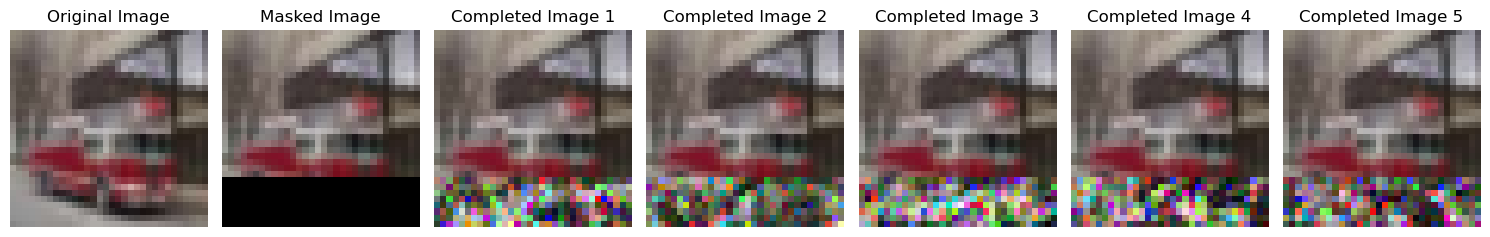

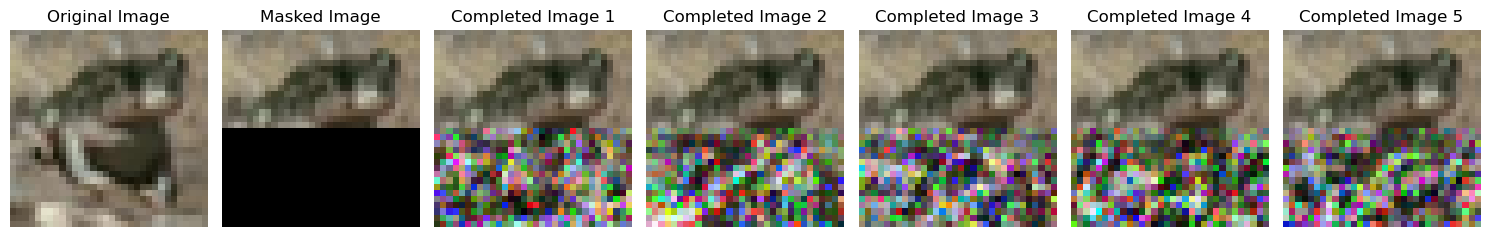

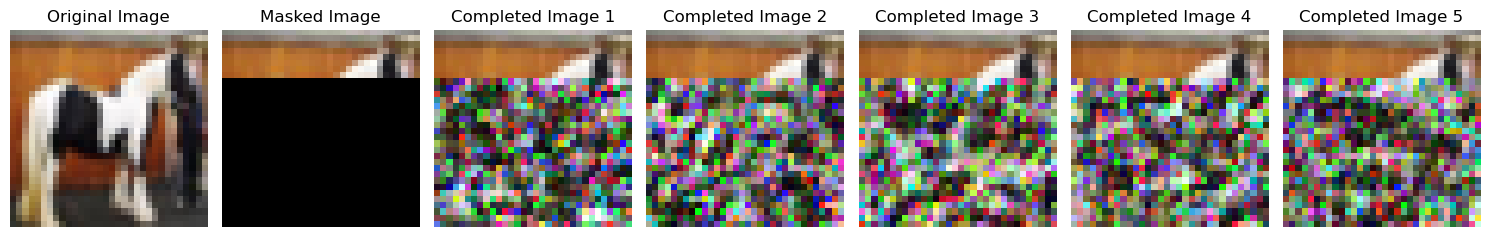

In [13]:
for i in range(3):
    original_img = completion.get_random_cifar10_image(ds)
    masked_img, mask = completion.mask_image(original_img)
    completed_img = completion.complete(PixelCNN, masked_img, mask)
    completion.plot_completed_images(original_img, masked_img, completed_img)

for i in range(3):
    original_img = completion.get_random_cifar10_image(ds)
    masked_img, mask = completion.mask_image(original_img, mask_fraction=0.25*(i+1))
    completed_img = completion.complete(PixelCNN, masked_img, mask)
    completion.plot_completed_images(original_img, masked_img, completed_img)